<a href="https://colab.research.google.com/github/BdNWoG/RLtest/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLab Onboarding Project, Fall 2023

Your task is to classify different species of birds! See the project document pinned in \#mlab-general for more details.

## Setup

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# workshop folder, e.g. 'acmlab/project'
FOLDERNAME = 'acmlab/project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
PATH = '/content/drive/My Drive/{}'.format(FOLDERNAME)
sys.path.append(PATH)

%cd $PATH

Mounted at /content/drive
/content/drive/My Drive/acmlab/project


In [ ]:
# Math/deep learning libraries
import numpy as np
import torch
from torch import nn

# Data processing
import pandas as pd

# Data transformations
import torchvision

# Loading images/bundles of images
from PIL import Image
import h5py

# Plotting
import matplotlib.pyplot as plt

# Progress bars
import tqdm

# Other
import time
from datetime import date

In [ ]:
# Set PyTorch to use the GPU
torch.manual_seed(0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Dataset

You'll need to create a way to load our training images into PyTorch.

Ordinarily, you would load images one at a time from a folder on your computer (or in our case, Google Drive). However, since Google Drive's file reading speed is extremely slow (on the order of 1 hour for the training dataset), this is inefficient for developing a model. Note that this *wouldn't* be the case if we were running locally, where file reading is much faster.

Since we still want you to get experience with creating an image dataset, we'll have you create it the traditional way (by loading images one at a time) on a **small dataset** that won't be used for actual training.

For the actual training dataset, we created an `h5py` bundle of the data, which allows you to read a single (larger) file to get a full list of images. Instead of reading the images individually, you'll be able to use the functions provided in `utils.py` to load lists of the images, labels, and classes.

### Loading images individually

Fill in the following class to load images one by one into a dataset. We provide a `csv_path` as an argument.

1. Load the CSV file using Pandas. The CSV is formatted as follows:
```
filepath,label,class
small_data/0 - GREAT XENOPS/0_1.jpg,0,GREAT XENOPS
...
small_data/2 - OSPREY/2_15.jpg,2,OSPREY
```

2. For each row of the CSV, read in the image at the `filepath`, and add the image and label to the `self.images` and `self.labels` list.

  We can load images with `Image.open(filename)`.

  We'll also want to keep track of the classes themselves, so `self.classes[0]` should equal the name of the bird with label 0 (`"GREAT XENOPS"`).

3. Fill in the rest of the functions based on the `self.images`, `self.labels`, and `self.classes` variables.

In [ ]:
class BirdDatasetSmall(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        self.images = []
        self.labels = []
        self.classes = []

        files = pd.read_csv(csv_path)
        for index, row in files.iterrows():
          print(index, row['class'])
          self.images.append(Image.open(row['filepath']))
          self.labels.append(row['label'])
          if row['class'] not in self.classes:
             self.classes.append(row['class'])

        assert len(self.images) == len(self.labels)

    def __len__(self):
        """Returns the number of examples in the dataset"""
        return len(self.images)

    def num_classes(self):
        """Returns the number of classes in the dataset"""
        return len(self.classes)

    def get_class(self, label):
        return self.classes[label]

    def get_image(self, idx):
        """Returns the image of the idx'th example in the dataset"""
        return self.images[idx]

    def get_label(self, idx):
        """Returns the label of the idx'th example in the dataset"""
        return self.labels[idx]

    def __getitem__(self, idx):
        """Returns a tuple of the image and label of the idx'th example in the dataset"""
        return (self.images[idx], self.labels[idx])

    def display(self, idx):
        """Displays the image at a given index"""
        display(self.get_image(idx))

#### Testing BirdDatasetSmall

First, we'll run some basic tests to make sure the dataset is reading the right values. The first time you run this cell, it might take about a minute to load the data.

In [ ]:
def test_case(message, value, expected_value):
    print(message)
    if value == expected_value:
        print("  PASSED")
    else:
        print(f"  EXPECTED: {expected_value}")
        print(f"  GOT: {value}")

small_dataset = BirdDatasetSmall("small_data.csv")

test_case("Length of the dataset", len(small_dataset), 45)
test_case("Label of idx=17", small_dataset.get_label(17), 1)

0 GREAT XENOPS
1 GREAT XENOPS
2 GREAT XENOPS
3 GREAT XENOPS
4 GREAT XENOPS
5 GREAT XENOPS
6 GREAT XENOPS
7 GREAT XENOPS
8 GREAT XENOPS
9 GREAT XENOPS
10 GREAT XENOPS
11 GREAT XENOPS
12 GREAT XENOPS
13 GREAT XENOPS
14 GREAT XENOPS
15 KIWI
16 KIWI
17 KIWI
18 KIWI
19 KIWI
20 KIWI
21 KIWI
22 KIWI
23 KIWI
24 KIWI
25 KIWI
26 KIWI
27 KIWI
28 KIWI
29 KIWI
30 OSPREY
31 OSPREY
32 OSPREY
33 OSPREY
34 OSPREY
35 OSPREY
36 OSPREY
37 OSPREY
38 OSPREY
39 OSPREY
40 OSPREY
41 OSPREY
42 OSPREY
43 OSPREY
44 OSPREY
Length of the dataset
  PASSED
Label of idx=17
  PASSED


Next, we'll display some images from the dataset. The output of running the cell should match the following image:

![](https://drive.google.com/uc?export=view&id=1mqvn-KXh8mWV6HcxulAnNqDhIPPWCq6f)

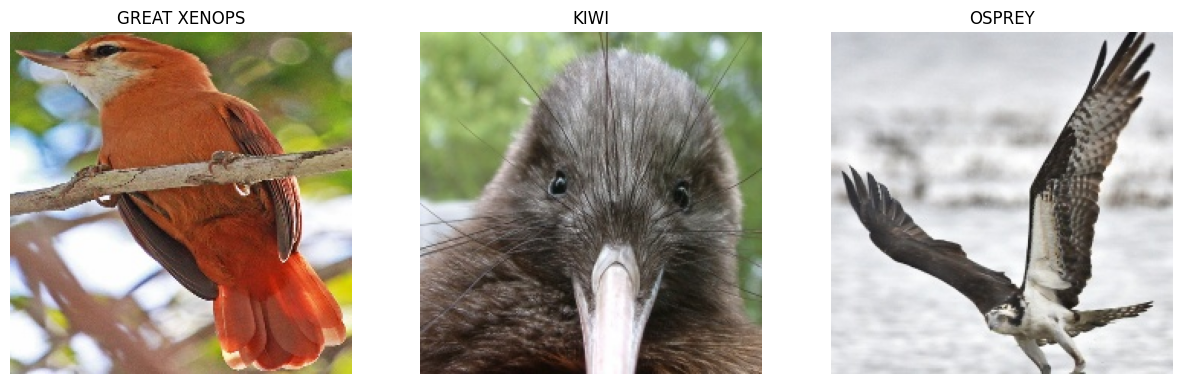

In [ ]:
# Display some images from all_data
figure = plt.figure(figsize=(15, 10))
num_rows = 1
num_cols = 3

ds_idx = [13, 29, 43]
for plot_idx, idx in enumerate(ds_idx):
    ax = plt.subplot(num_rows, num_cols, plot_idx + 1) # subplot indices begin at 1, not 0
    ax.title.set_text(small_dataset.get_class(small_dataset.get_label(idx)))
    plt.axis('off')
    plt.imshow(small_dataset.get_image(idx))

### Loading images from a bundle

As mentioned previously, for Colab performance reasons we'll be loading all the training data from a pre-created HDF5 bundle.

You'll be filling in the same code as the previous dataset, but instead of loading images one by one, you will use the `utils.load_data()` function, which returns a tuple of a list of images, a list of labels, and a list of classes.

The other difference is the inclusion of a `transform` parameter. This is a `torchvision` Transform that should be applied to each image in `__getitem__` before returning.

In [ ]:
import utils

In [ ]:
def calculate_data_properties():
  data = utils.load_data()
  temp_images, _, _ = data
  running_sum = np.zeros(temp_images.shape[-1])
  for img in temp_images:
    running_sum += img.mean(axis=(0,1))

  mean = running_sum/(temp_images.shape[0])

  dev = np.zeros(temp_images.shape[-1])
  for img in temp_images:
    dev += ((img - mean)**2).sum(axis=(0,1))

  std = np.sqrt(dev/(temp_images.shape[0]*temp_images.shape[1]*temp_images.shape[2]))

  return mean, std

In [ ]:
!pip uninstall utils

In [ ]:
import utils

class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.images = []
        self.labels = []
        self.classes = []
        self.transform = transform

        data = utils.load_data()

        self.images, self.labels, self.classes = data

        assert len(self.images) == len(self.labels)

    def __len__(self):
        """Returns the number of examples in the dataset"""
        return len(self.images)

    def num_classes(self):
        """Returns the number of classes in the dataset"""
        return len(self.classes)

    def get_class(self, label):
        """Returns the name of the bird corresponding to the given label value"""
        return self.classes[label]

    def get_image(self, idx):
        """Returns the image of the idx'th example in the dataset"""
        return self.images[idx]

    def get_label(self, idx):
        """Returns the label of the idx'th example in the dataset"""
        return self.labels[idx]

    def __getitem__(self, idx):
        """Returns a tuple of the *transformed* image and label of the idx'th example in the dataset"""
        return (self.transform(self.images[idx]), self.labels[idx])

    def display(self, idx):
        """Displays the image at a given index"""
        display(self.get_image(idx))

## Creating and visualizing the dataset

First, let's create the `BirdDataset`. Be sure to pass in the transform as a parameter. We're using a `ToTensor()` transform to ensure that when PyTorch goes through the dataset, it reads the images as Tensors instead of images.

The first time you run this cell, it'll take about a minute to load the file.

In [ ]:
mean, std = calculate_data_properties()

transform = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean, std)
  ])

all_data = BirdDataset(transform)

### Visualizing the data

An important part of deep learning is to understand what type of data we're working with. Here, we'll visualize some of the examples of our training set.

In [ ]:
len(all_data.classes)

20

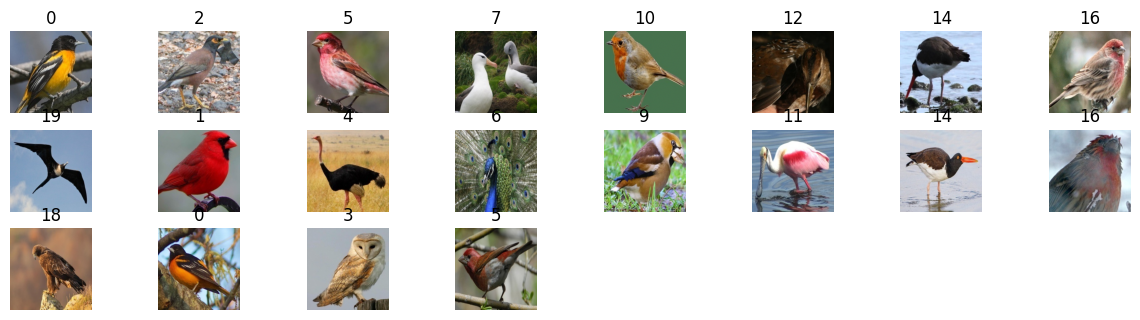

In [ ]:
# Display some images from all_data
figure = plt.figure(figsize=(15, 10))
num_rows = 8
num_cols = 8
for plot_idx in range(20):
    ax = plt.subplot(num_rows, num_cols, plot_idx + 1) # subplot indices begin at 1, not 0
    idx = (plot_idx * 373) % len(all_data.labels)  # Gets a "random" index in the dataset
    # for this code, use `idx` as the dataset index
    cur_image = all_data.get_image(idx)
    cur_label = all_data.get_label(idx)

    ax.title.set_text(cur_label)
    plt.axis('off')
    plt.imshow(cur_image)

## Model structure

Here's where you'll define the structure of your neural network. Refer back to earlier workshop notebooks for reference.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BirdModel(nn.Module):
    def __init__(self, num_classes=20):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 6, 11) # 3 x 224 x 224 -> 6 x 214 x 214
      self.pool1 = nn.MaxPool2d(2, 2) # 6 x 107 x 107
      self.norm1 = nn.BatchNorm2d(6)
      self.dropout1 = nn.Dropout(p=0.1)

      self.conv2 = nn.Conv2d(6, 12, 5) # 12 x 103 x 103
      self.pool2 = nn.MaxPool2d(2, 2) # 12 x 51 x 51
      self.norm2 = nn.BatchNorm2d(12)
      self.dropout2 = nn.Dropout(p=0.1)

      self.conv3 = nn.Conv2d(12, 24, 3) # 24 x 49 x 49
      self.pool3 = nn.MaxPool2d(2, 2) # 24 x 24 x 24
      self.norm3 = nn.BatchNorm2d(24)

      self.fc1 = nn.Linear(24*24*24, 2500)
      self.fc2 = nn.Linear(2500, 500)
      self.fc3 = nn.Linear(500, 100)
      self.fc4 = nn.Linear(100, 20)

    def forward(self, x):
      x = self.pool1(F.relu(self.conv1(x)))
      x = self.norm1(x)
      x = self.dropout1(x)
      x = self.pool2(F.relu(self.conv2(x)))
      x = self.norm2(x)
      x = self.dropout2(x)
      x = self.pool3(F.relu(self.conv3(x)))
      x = x.view(-1, 24*24*24)
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      x = self.fc4(x)
      return x

"""
import torch.nn as nn
import torch.nn.functional as F

class BirdModel(nn.Module):
    def __init__(self, num_classes=20):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 6, 5) # 3 x 224 x 224 -> 6 x 220 x 220
      self.conv2 = nn.Conv2d(6, 15, 5) # 15 x 106 x 106
      self.pool1 = nn.MaxPool2d(2, 2) # 15 x 53 x 53
      self.conv3 = nn.Conv2d(15, 30, 5) # 30 x 49 x 49
      self.conv4 = nn.Conv2d(30, 30, 3) # 30 x 48 x 48
      self.pool2 = nn.MaxPool2d(2, 2) # 30 x 24 x 24
      self.fc1 = nn.Linear(30*24*24, 400)
      self.fc2 = nn.Linear(400, 20)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = self.pool1(x)
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = self.pool2(x)
      x = x.view(-1, 30*24*24)
      x = self.fc1(x)
      x = self.fc2(x)
      return x
"""

'\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass BirdModel(nn.Module):\n    def __init__(self, num_classes=20):\n      super().__init__()\n      self.conv1 = nn.Conv2d(3, 6, 5) # 3 x 224 x 224 -> 6 x 220 x 220\n      self.conv2 = nn.Conv2d(6, 15, 5) # 15 x 106 x 106\n      self.pool1 = nn.MaxPool2d(2, 2) # 15 x 53 x 53\n      self.conv3 = nn.Conv2d(15, 30, 5) # 30 x 49 x 49\n      self.conv4 = nn.Conv2d(30, 30, 3) # 30 x 48 x 48\n      self.pool2 = nn.MaxPool2d(2, 2) # 30 x 24 x 24\n      self.fc1 = nn.Linear(30*24*24, 400)\n      self.fc2 = nn.Linear(400, 20)\n\n    def forward(self, x):\n      x = F.relu(self.conv1(x))\n      x = F.relu(self.conv2(x))\n      x = self.pool1(x)\n      x = F.relu(self.conv3(x))\n      x = F.relu(self.conv4(x))\n      x = self.pool2(x)\n      x = x.view(-1, 30*24*24)\n      x = self.fc1(x)\n      x = self.fc2(x)\n      return x\n'

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

sample_model = BirdModel()
count_parameters(sample_model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    2178    |
|  conv1.bias  |     6      |
| norm1.weight |     6      |
|  norm1.bias  |     6      |
| conv2.weight |    1800    |
|  conv2.bias  |     12     |
| norm2.weight |     12     |
|  norm2.bias  |     12     |
| conv3.weight |    2592    |
|  conv3.bias  |     24     |
| norm3.weight |     24     |
|  norm3.bias  |     24     |
|  fc1.weight  |  34560000  |
|   fc1.bias   |    2500    |
|  fc2.weight  |  1250000   |
|   fc2.bias   |    500     |
|  fc3.weight  |   50000    |
|   fc3.bias   |    100     |
|  fc4.weight  |    2000    |
|   fc4.bias   |     20     |
+--------------+------------+
Total Trainable Params: 35871816


35871816

## Training setup

### Hyperparameters

Here's where we'll define our hyperparameters. We put them all in this cell for ease of readability; if you choose to add more hyperparameters, we suggest you add them here.

As you're tuning your model, change these values how you see fit!

In [ ]:
batch_size = 32
learning_rate = 0.001
num_epochs = 20

### Data Augmentation

If you choose to use data augmentation, add your augmentation transforms here.

In [ ]:
aug = torchvision.transforms.Compose([
    #torchvision.transforms.RandomRotation(60),
    torchvision.transforms.RandomResizedCrop(224,(0.8,1.0)),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Data loaders

Here we'll create the data loaders for the train and validation set. To split `all_data` into the training and validation sets, read the PyTorch documentation for `random_split`: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

Be sure to pass in the `batch_size` hyperparameter to the DataLoaders, and be sure to shuffle the training data loader!

In [ ]:
from torch.utils.data import DataLoader

train_len = len(all_data)*0.8
val_len = len(all_data)*0.2

train_set, val_set = torch.utils.data.random_split(all_data, [0.8, 0.2])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
train_len

2490.4

In [ ]:
counter=0
for images, targets in train_loader:
  if counter==0:
    print(images)
    print(targets)
  counter+=1

## Training

It's time to train our model!

### Evaluation function

First, let's create a function that evaluates the accuracy of a model on a specified dataset. We provide some of the skeleton code, but you'll be coding this one on your own!

Be sure to call `.to(device=device)` on any data tensors to make sure PyTorch is using the GPU.

In [ ]:
# split is a variable you can set as the "name" of the dataset (either "train" or "val")
def evaluate(model, data_loader, name="val"):
    correct = 0  # number of correct predictions
    total = 0    # total number of examples in the data loader

    with torch.inference_mode():
        model.eval()
        for inputs, labels in data_loader:
            inputs = inputs.to(device=device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(device=device)
            labels = labels.to(torch.float32)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        model.train()

    print(f'Accuracy of the network on the {total} {name} images: {100 * correct / total}%')

In [ ]:
evaluate(model, val_loader)

Accuracy of the network on the 622 val images: 48.231511254019296%


In [ ]:
import statistics

def get_val_loss(model, loader, criterion):
  val_loss = []
  for inputs, labels in loader:
    inputs = inputs.to(device=device)
    inputs = inputs.to(torch.float32)
    labels = labels.to(device=device)

    pred_y = model(inputs).squeeze()
    loss = criterion(pred_y, labels)
    val_loss.append(loss)

  val_loss = [i.item() for i in val_loss]
  return statistics.mean(val_loss)

### Training loop

This is it: this is where your model learns! You'll also be implementing this function on your own. A couple tips:
* Be sure to apply augmentations to your data if you're using them
* Be sure to call `.to(device=device)` on your model and any data tensors to make sure PyTorch is using the GPU
* Call `evaluate` on both the train and validation data loaders after each epoch

In [ ]:
train_loss = []
val_loss = []

model = BirdModel().to(device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

start_time = time.time()
for epoch in range(num_epochs):

  for i, (images, targets) in enumerate(train_loader):
    optimizer.zero_grad()
    images = images.to(device=device)
    images = images.to(torch.float32)
    aug_images = [aug(im) for im in images]
    aug_images.extend([aug(im) for im in images])
    aug_images.extend([aug(im) for im in images])

    for im in aug_images:
      images = torch.cat((images, im.unsqueeze(0)),0)

    targets = targets.to(device=device)
    targets = torch.cat((targets, targets, targets, targets), 0)

    pred_y = model(images).squeeze()
    loss = criterion(pred_y, targets)
    train_loss.append(loss)
    val_loss.append(get_val_loss(model, val_loader, criterion))

    loss.backward()
    optimizer.step()

  evaluate(model, val_loader)
  evaluate(model, train_loader, "train")

end_time = time.time()
print(f"Total training time: {end_time - start_time} sec")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of the network on the 622 val images: 12.057877813504824%
Accuracy of the network on the 2491 train images: 11.963067041348856%
Accuracy of the network on the 622 val images: 17.041800643086816%
Accuracy of the network on the 2491 train images: 20.95543958249699%
Accuracy of the network on the 622 val images: 22.34726688102894%
Accuracy of the network on the 2491 train images: 25.291047771979123%
Accuracy of the network on the 622 val images: 32.958199356913184%
Accuracy of the network on the 2491 train images: 38.45845042151746%
Accuracy of the network on the 622 val images: 32.958199356913184%
Accuracy of the network on the 2491 train images: 37.8964271376957%
Accuracy of the network on the 622 val images: 41.961414790996784%
Accuracy of the network on the 2491 train images: 45.44359694901646%
Accuracy of the network on the 622 val images: 38.263665594855304%
Accuracy of the network on the 2491 train images: 46.40706543556804%
Accuracy of the network on the 622 val images: 4

In [ ]:
train_loss = [i.item() for i in train_loss]

<Axes: >

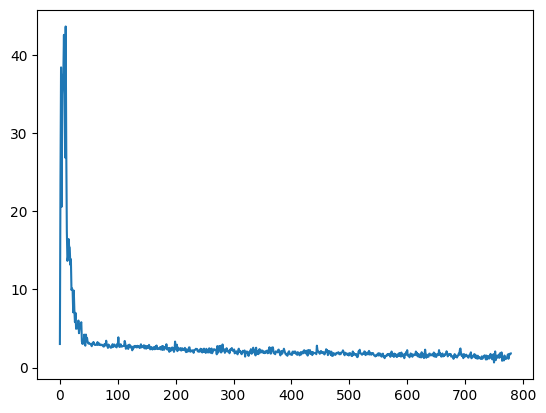

In [ ]:
import seaborn as sns
sns.lineplot(train_loss)

<Axes: >

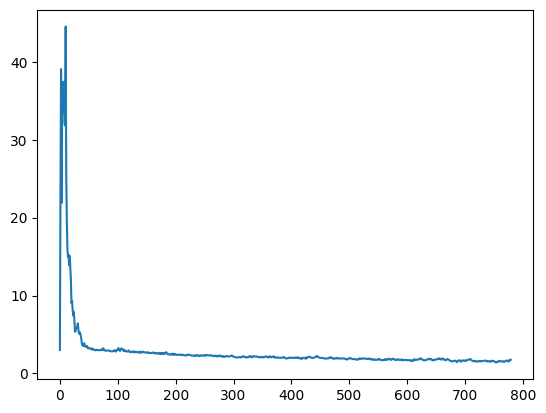

In [ ]:
sns.lineplot(val_loss)

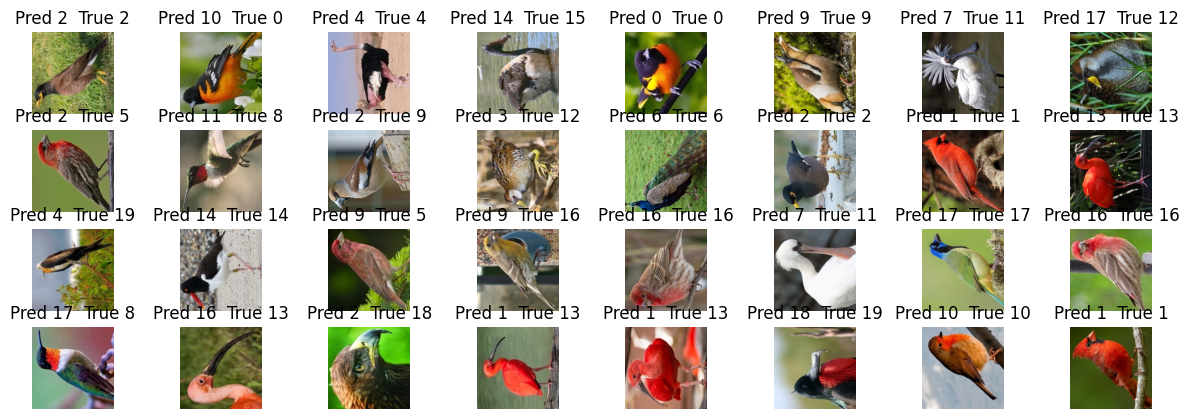

In [ ]:
images, labels = next(iter(val_loader))
aug_images = [aug(i) for i in images]
outputs = model(images.to(device=device).to(torch.float32))
_, predicted = torch.max(outputs.data, 1)

figure = plt.figure(figsize=(15, 10))
num_rows = 8
num_cols = 8
for idx in range(32):
  plt.subplot(num_rows, num_cols, idx + 1) # subplot indices begin at 1, not 0
  plt.axis('off')
  plt.title('Pred '+str(predicted[idx].item())+'  True '+str(labels[idx].item()))
  plt.imshow(images[idx].T.squeeze())

In [ ]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [ ]:
torch.tensor(all_data.get_image(5)).shape

torch.Size([224, 224, 3])

In [ ]:
aug(torch.tensor(all_data.get_image(5))).shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([224, 224, 224])

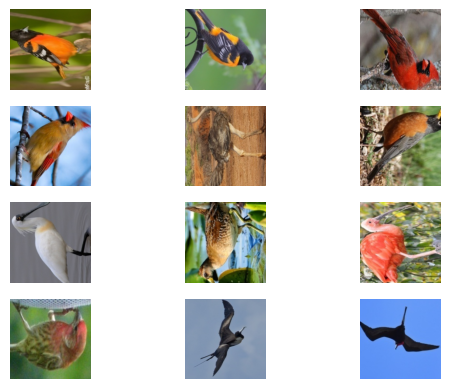

In [ ]:
indexes_of_images_to_get = [4, 120, 145, 148, 650, 1500, 1685, 1948, 2014, 2499, 3002, 3012]
num_rows=4
num_cols=3
for i, idx in enumerate(indexes_of_images_to_get):
  plt.subplot(num_rows, num_cols, i+1) # subplot indices begin at 1, not 0
  plt.axis('off')
  img = torch.tensor(all_data.get_image(idx))
  img = torch.permute(img, (2, 0, 1))
  plt.imshow(aug(img).T.squeeze())
  #plt.imshow(img.T.squeeze())

### Saving model weights

Save your weights! Your final model's weights will be one component of your submission. We recommend saving weights with a recognizable name, such as the date and a short description of the structure of your model (e.g. `"2023_10_25_3LayerCNN"`)

In [ ]:
model_name = "model1-57"  ### CHANGE THIS NAME EACH TIME YOU SAVE WEIGHTS! ###

date_str = date.today().strftime("%Y_%m_%d")
model_weights_filename = f"{date_str}_{model_name}.pt"

torch.save(model.state_dict(), f"{model_weights_filename}")
print(f"Model weights saved as {model_weights_filename}")

Model weights saved as 2023_11_29_model1-57.pt


### Refining your model

Now that you've trained a basic model, it's time to see if you can improve its accuracy. Feel free to change anything – the model structure, hyperparameters, augmentation – or try employing training strategies like regularization or early stopping. Get creative!

## Predict functions

These functions will let us run the test set through your model. It is **incredibly important** that you implement these functions!

`predict` should load the image at the specified path, run it through the model (variable provided as a parameter), and output the **predicted label** (the single numerical value between 0 and 19) – *not* the class name (e.g. the name of the bird).

In [ ]:
def load_model():
    model_path = ### FILL THIS IN WITH YOUR FINAL CHECKPOINT FILENAME ###

    model = BirdModel()
    model.load_state_dict(torch.load(model_path))
    return model

In [ ]:
def predict(model, image_path):
    prediction = None
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)

    return prediction

Notes: Add zoom-in data augmentation